<a href="https://colab.research.google.com/github/Nov05/DS-Unit-2-Tree-Ensembles/blob/master/module3-confusion-matrix/kaggle_20190715.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# created by nov05 on 2019-07-15
# Kaggle
# DS-Unit-2-Tree-Ensembles/
# module1-decision-trees/
# module2-random-forests/
# module3-confusion-matrix/
# module4-roc-auc/

competition_name = "ds5-predictive-modeling-challenge"

**Leaderboard**  
https://www.kaggle.com/c/ds5-predictive-modeling-challenge/leaderboard  

**Adopting a Hypothesis-Driven Modeling Workflow**  
https://outline.com/5S5tsB  

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# do this only once unless you create a new API key:
# create a folder with name "config" in "My Drive" 
# and store your API config file "kaggle.json" there

# do this every time after you reset all your runtimes,
# or kaggle won't find your API config file "kaggle.json" 
%env KAGGLE_CONFIG_DIR=/content/drive/My Drive/config

env: KAGGLE_CONFIG_DIR=/content/drive/My Drive/config


In [0]:
# run this code block to download competition files
!kaggle competitions download -c ds5-predictive-modeling-challenge
# unzip all .zip files
!unzip \*.zip

# Imports

In [0]:
!pip install --upgrade pandas-profiling
!pip install category_encoders

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import datetime as dt
from itertools import chain

import sklearn
from sklearn import datasets

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, \
     ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, \
     mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, \
     GridSearchCV
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, \
     OneHotEncoder, OrdinalEncoder, LabelEncoder

import category_encoders as ce
from category_encoders.binary import BinaryEncoder

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [0]:
print("pandas_profiling", pandas_profiling.__version__)
print("category_encoders", ce.__version__)
print("pandas", pd.__version__)
print("sklearn", sklearn.__version__)

pandas_profiling 2.1.2
category_encoders 2.0.0
pandas 0.24.2
sklearn 0.21.2


# Download data

In [0]:
LOCAL = '../data/tanzania/'
# WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/'
WEB = '' # if you have downloaded the files to Colab folder '/content'

train_features = pd.read_csv(WEB + 'train_features.csv')
train_labels = pd.read_csv(WEB + 'train_labels.csv')
test_features = pd.read_csv(WEB + 'test_features.csv')
sample_submission = pd.read_csv(WEB + 'sample_submission.csv')

assert train_features.shape == (59400, 40)
assert train_labels.shape == (59400, 2)
assert test_features.shape == (14358, 40)
assert sample_submission.shape == (14358, 2)

In [0]:
X_train = train_features
y_train = train_labels['status_group']
X_test = test_features

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=0.80, test_size=0.20,
    stratify=y_train, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape, \
X_test.shape, test_features.shape

((47520, 40), (11880, 40), (47520,), (11880,), (14358, 41), (14358, 41))

# Feature examination/engineering

In [0]:
pd.DataFrame(train_features.isna().sum()).T

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,0,0,0,3635,0,3655,0,0,0,0,0,371,0,0,0,0,0,0,3334,0,3877,28166,3056,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
pd.DataFrame(train_features['region_code'].value_counts()).T

,11,17,12,3,5,18,19,2,16,10,4,1,13,14,20,15,6,21,80,60,90,7,99,9,24,8,40
region_code,5300,5011,4639,4379,4040,3324,3047,3024,2816,2640,2513,2201,2093,1979,1969,1808,1609,1583,1238,1025,917,805,423,390,326,300,1


### Find regional values

In [0]:
cols_zero = ['longitude', 'latitude', 'gps_height', 'population', 'construction_year']
cols = ['region_code'] + cols_zero
df_median = train_features[cols].groupby(by='region_code').median()
df_median

,longitude,latitude,gps_height,population,construction_year
region_code,,,,,
1,35.972239,-6.101568,0.0,0.0,0.0
2,36.738449,-3.330040,1371.0,150.0,2000.0
3,37.521564,-3.313371,1241.0,40.0,2002.0
4,38.502044,-5.007137,301.0,70.0,1994.0
5,36.997507,-7.237802,324.0,200.0,1997.0
6,38.849318,-6.632176,62.0,50.0,2007.0
7,39.174331,-6.908980,29.0,150.0,2000.0
8,38.637849,-10.272418,352.0,270.0,1979.0
9,39.681427,-10.731491,219.0,217.5,1982.0


In [0]:
df_median.replace(0, np.nan, inplace=True)
df_median.fillna(method='bfill', inplace=True)
df_median

,longitude,latitude,gps_height,population,construction_year
region_code,,,,,
1,35.972239,-6.101568,1371.0,150.0,2000.0
2,36.738449,-3.330040,1371.0,150.0,2000.0
3,37.521564,-3.313371,1241.0,40.0,2002.0
4,38.502044,-5.007137,301.0,70.0,1994.0
5,36.997507,-7.237802,324.0,200.0,1997.0
6,38.849318,-6.632176,62.0,50.0,2007.0
7,39.174331,-6.908980,29.0,150.0,2000.0
8,38.637849,-10.272418,352.0,270.0,1979.0
9,39.681427,-10.731491,219.0,217.5,1982.0


In [0]:
X_train.select_dtypes(include=np.number).columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year'],
      dtype='object')

In [0]:
X_train['date_recorded'].describe()

count          47520
unique           349
top       2011-03-17
freq             474
Name: date_recorded, dtype: object

In [0]:
# no missing values
timeseries = pd.to_datetime(X_train['date_recorded'], infer_datetime_format=True)
days_recorded = (timeseries - min(timeseries)).dt.days
pd.Series(days_recorded).describe()

count    47520.000000
mean      3454.199705
std        334.481142
min          0.000000
25%       3091.000000
50%       3649.000000
75%       3771.000000
max       4068.000000
Name: date_recorded, dtype: float64

### Categorical features

In [0]:
# drop this column
X_train['recorded_by'].value_counts()

GeoData Consultants Ltd    47520
Name: recorded_by, dtype: int64

In [0]:
X_train[['water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group']].describe()

,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,47520,47520,47520,47520,47520,47520,47520,47520,47520
unique,8,6,5,5,10,7,3,7,6
top,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,40598,40598,26567,26567,13620,13620,36638,22778,27642


In [0]:
X_train[['extraction_type', 'extraction_type_group', 'extraction_type_class']].describe()

,extraction_type,extraction_type_group,extraction_type_class
count,47520,47520,47520
unique,18,13,7
top,gravity,gravity,gravity
freq,21448,21448,21448


In [0]:
print(X_train['region'].value_counts().shape[0])
print(X_train['region_code'].value_counts().shape[0])
X_train[['region', 'region_code']].head()

21
27


,region,region_code
43360,Mbeya,12
7263,Iringa,11
2486,Pwani,6
313,Kagera,18
52726,Dodoma,1


### Numeric features

In [0]:
X_train.select_dtypes(include=np.number).head()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
43360,72938,0.0,0,33.542898,-9.174777,0,12,4,0,0
7263,65358,500.0,2049,34.665760,-9.308548,0,11,4,175,2008
2486,469,25.0,290,38.238568,-6.179919,0,6,1,2300,2010
313,1298,0.0,0,30.716727,-1.289055,0,18,1,0,0
52726,27001,0.0,0,35.389331,-6.399942,0,1,6,0,0


In [0]:
# maybe drop this column?
print(len(X_train['num_private'].value_counts()))
X_train['num_private'].value_counts()[:10]

59


0     46932
6        60
1        59
8        40
5        37
32       35
39       24
45       23
7        22
2        21
Name: num_private, dtype: int64

In [0]:
null_lands = train_features[train_features['longitude']<=0.1]
print(null_lands.shape)
null_lands[cols_zero].head(2)

(1812, 40)


,longitude,latitude,gps_height,population,construction_year
21,0.0,-2.000000e-08,0,0,0
53,0.0,-2.000000e-08,0,0,0


In [0]:
# Infinite values
X_train['pop_lg'] = np.log(X_train['population'])
print(X_train['pop_lg'].isna().sum())
print(X_train['pop_lg'].replace([np.inf, -np.inf], np.nan).isna().sum())

0
17066


In [0]:
cols = cols_zero + ['region_code']
row = X_train[cols].head(1)
print(df_median.loc[row['region_code'], 'construction_year'])
X_train[cols].head(1)

region_code
12    2000.0
Name: construction_year, dtype: float64


,longitude,latitude,gps_height,population,construction_year,region_code
43360,33.542898,-9.174777,0,0,0,12


In [0]:
# df_median = regional values
print(df_median.loc[1,'longitude'])
df_median.columns.to_list()

35.97223854


['longitude', 'latitude', 'gps_height', 'population', 'construction_year']

In [0]:
def fill_median(row):
  for col in cols_zero:
    if np.isnan(row[col]):
      row[col] = df_median.loc[row['region_code'], col]
  return row
  
def wrangler(df, cols_zero=cols_zero):
  for col in cols_zero:
    df[col].replace(0, np.nan, inplace=True)
  df['latitude'].replace(-2.000000e-08, np.nan, inplace=True)
  
  # fill with regional values
  cols = cols_zero + ['region_code']
  df[cols] = df[cols].apply(fill_median, axis=1)
  
  df['pop_lg'] = np.log(df['population'])
  df['pop_lg'].replace([np.inf, -np.inf], np.nan, inplace=True)
  
  timeseries = pd.to_datetime(df['date_recorded'], infer_datetime_format=True)
  df['days_recorded'] = (timeseries - min(timeseries)).dt.days

# check values
dfs = [X_train, X_val, X_test]
cols = cols_zero + ['pop_lg']
for d in dfs:
  wrangler(d)
  print(d[cols].isna().sum())
  print(np.isinf(d[cols]).sum())
  print()

longitude            0
latitude             0
gps_height           0
population           0
construction_year    0
pop_lg               0
dtype: int64
longitude            0
latitude             0
gps_height           0
population           0
construction_year    0
pop_lg               0
dtype: int64

longitude            0
latitude             0
gps_height           0
population           0
construction_year    0
pop_lg               0
dtype: int64
longitude            0
latitude             0
gps_height           0
population           0
construction_year    0
pop_lg               0
dtype: int64

longitude            0
latitude             0
gps_height           0
population           0
construction_year    0
pop_lg               0
dtype: int64
longitude            0
latitude             0
gps_height           0
population           0
construction_year    0
pop_lg               0
dtype: int64



In [0]:
cols = ['id'] + ['region_code'] + cols_zero
df = X_train[cols].append(X_val[cols], ignore_index=True)
df['status_group'] = train_labels['status_group']
df['region_code_str'] = 'region_' + df['region_code'].astype('str')
df.describe()

,id,region_code,longitude,latitude,gps_height,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,15.297003,35.084525,-5.797934,1124.660278,264.286414,1997.114040
std,21453.128371,17.587406,2.593514,2.811667,533.059743,454.661862,10.308466
min,0.000000,1.000000,29.607122,-11.649440,-90.000000,1.000000,1960.000000
25%,18519.750000,5.000000,33.091138,-8.541226,836.000000,80.000000,1993.000000
50%,37061.500000,12.000000,34.908743,-5.022018,1295.000000,200.000000,1998.000000
75%,55656.500000,17.000000,37.178387,-3.342792,1481.000000,300.000000,2004.000000
max,74247.000000,99.000000,40.345193,-0.998464,2770.000000,30500.000000,2013.000000


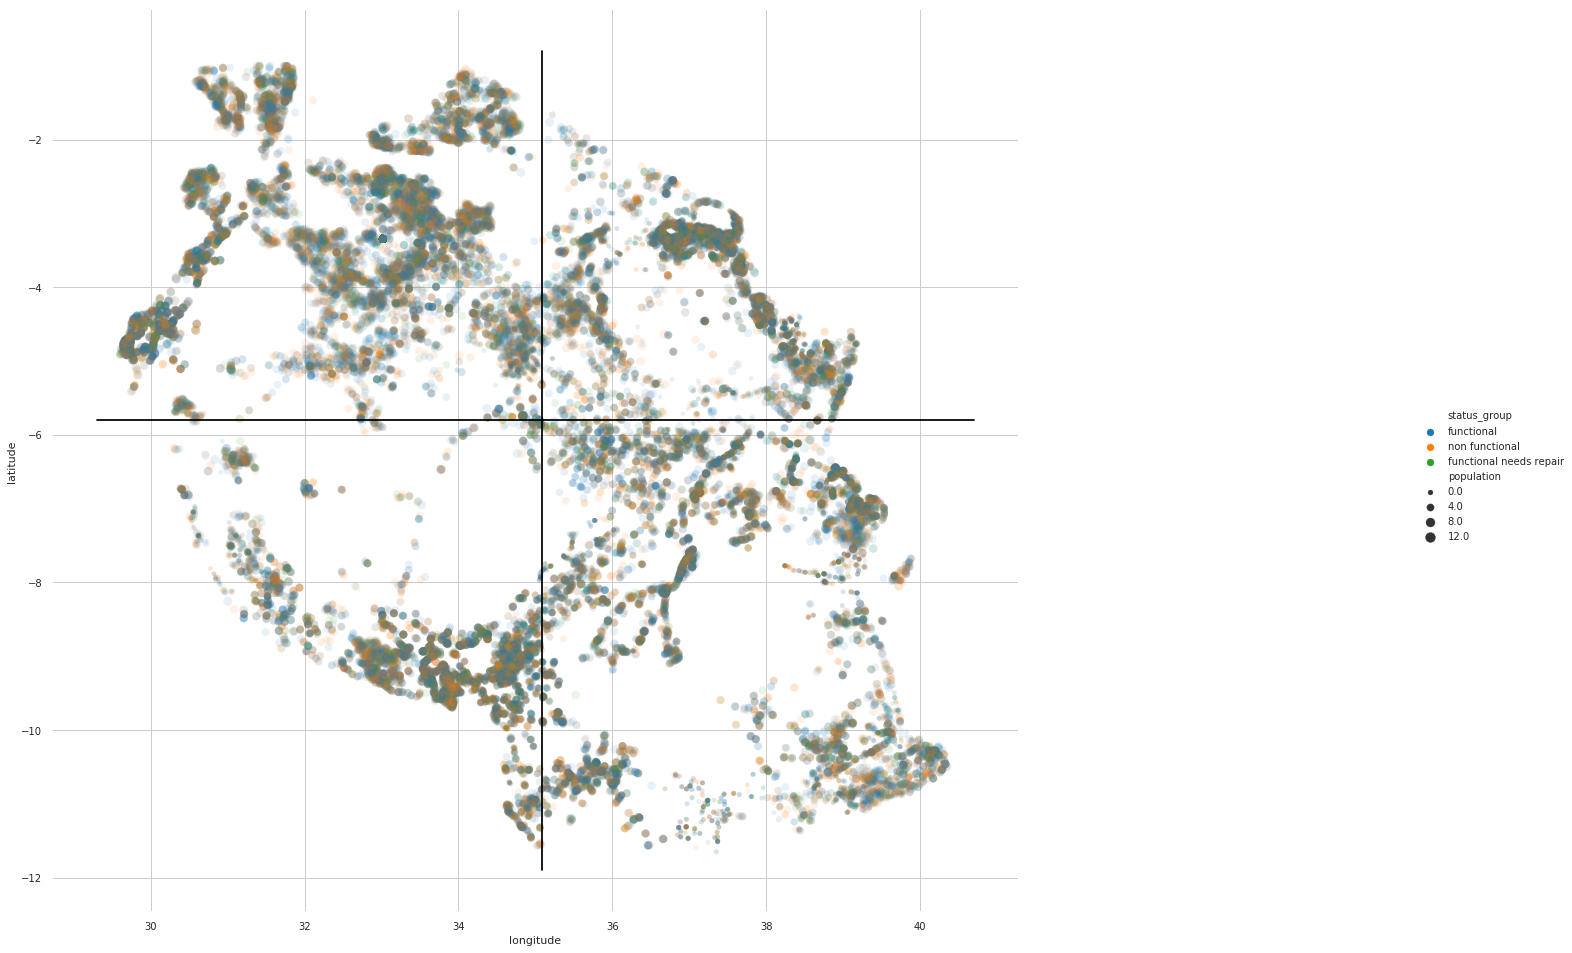

In [0]:
sns.set_style("whitegrid")
g = sns.relplot(x='longitude', y='latitude', 
                hue='status_group', 
#                 hue='region_code',
#                 hue='region_code_str',
                data=df,
#                 data=df[df['status_group']=='functional needs repair'], 
#                 data=df[df['status_group']=='non functional'],
#                 data=df[df['status_group']=='functional'],
                size=np.log(df['population']),
                alpha=0.1, linewidth=0)
mean = df['longitude'].mean()
plt.plot([mean,mean],[-11.9,-0.8], color='black')
mean = df['latitude'].mean()
plt.plot([29.3,40.7],[mean,mean], color='black')
g.fig.set_size_inches(25,15);

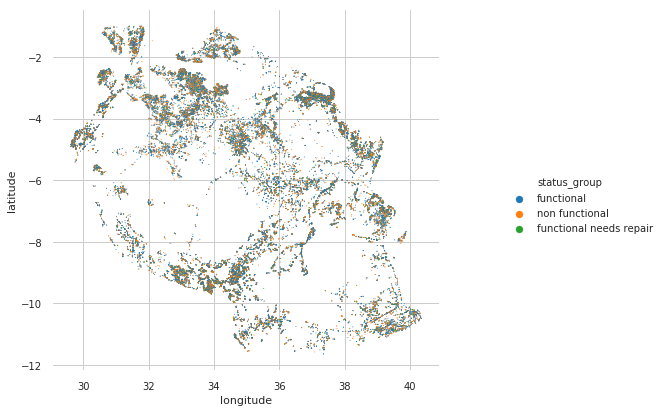

In [0]:
g = sns.relplot(x='longitude', y='latitude', hue='status_group', 
                data=df, alpha=1, s=0.9, linewidth=0)
g.fig.set_size_inches(10,6);

<img src="http://www.lonelyplanet.com/maps/africa/tanzania/map_of_tanzania.jpg" height="300">
<img src="https://www.researchgate.net/publication/312373453/figure/fig1/AS:471438105812994@1489411011502/Map-of-the-nine-River-Basin-Offices-in-Tanzania.png" height="300">

In [0]:
# engineer this column? distance to basin center?
X_train['basin'].value_counts()

Lake Victoria              8137
Pangani                    7173
Rufiji                     6412
Internal                   6255
Lake Tanganyika            5194
Wami / Ruvu                4773
Lake Nyasa                 4075
Ruvuma / Southern Coast    3551
Lake Rukwa                 1950
Name: basin, dtype: int64

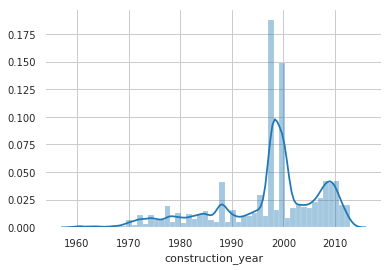

In [0]:
# imputed median
sns.distplot(X_train['construction_year']);

### Choose features

In [0]:
pd.DataFrame(X_train.isna().sum()).T

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,pop_lg
0,0,0,0,2904,0,2917,0,0,0,0,0,286,0,0,0,0,0,0,2644,0,3128,22532,2443,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
print(X_train.shape[1])
X_train.columns

42


Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'pop_lg', 'days_recorded'],
      dtype='object')

In [88]:
# remove some features
features = X_train.columns.to_list()
fs = ['quality_group',
      'quantity_group',
      'source_type',
      'source_class',
      'waterpoint_type_group',
      'extraction_type_group',
      'extraction_type_class',
      'id',
#       'date_recorded',
      'days_recorded', # use 'date_recorded'
      'region',
      'district_code',
      'population', # use 'pop_lg' instead
#       'pop_lg', # use 'population'
#       'num_private', # maybe not
     ]
for f in fs:
  features.remove(f)
print(len(features))

30


# Preprocessing

In [89]:
categorical_features, boolean_features = [], []

numeric_features = X_train[features].select_dtypes(include=np.number).columns.to_list()
categorical_features = X_train[features].select_dtypes(exclude=np.number).columns.to_list()
# for col in X_train[features].select_dtypes(exclude=np.number):
#   if isinstance(X_train[col][0], bool):
#     boolean_features.append(col)
#   else:
#     categorical_features.append(col)
len(numeric_features), len(categorical_features), len(boolean_features)

(8, 22, 0)

In [90]:
# select high cardinality features
# for ordinal encoding (rather than one-hot encoding)
highcardi_features, lowcardi_features = [], []
for col in X_train[categorical_features]:
  if len(X_train[col].value_counts()) >= 10:
    highcardi_features.append(col)
  elif len(X_train[col].value_counts()) >= 2:
    lowcardi_features.append(col)
len(numeric_features), len(boolean_features), len(highcardi_features), len(lowcardi_features)

(8, 0, 12, 9)

In [0]:
f = 'region_code'
if f in numeric_features:
  numeric_features.remove(f)
  highcardi_features.append(f)
#   lowcardi_features.append(f)

# Modeling  

https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf  


In [129]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
## sparse=False would exaust the memory    
#     ('onehot', OneHotEncoder(sparse=True, handle_unknown='ignore')), 
    ('onehot', ce.OneHotEncoder(drop_invariant=True, use_cat_names=True))]) 
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', ce.OrdinalEncoder())])
# boolean_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
#         ('boo', boolean_transformer, boolean_features),
        ('one', onehot_transformer, lowcardi_features), # categorical_features
        ('ord', ordinal_transformer, highcardi_features),
    ])

boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
parameters = {'n_estimators': (1, 50),
              'base_estimator__max_depth': (1, 26),
              'algorithm': ('SAMME', 'SAMME.R')}

## 2019-07-18 interesting results...
# class_weight = {'functional':1, 
#                 'non functional':5, 
#                 'functional needs repair':10}
class_weight = 'balanced'

clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('pca', PCA(whiten=True)), # n_components=0.9, 
#                       ('svd', TruncatedSVD(n_components=200, random_state=5)), # 200059 cols
#                       ('lr', LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)),
#                       ('dt', DecisionTreeClassifier(max_depth=26)),
#                       ('et', ExtraTreesClassifier(max_depth=28)), # 0.788
#                         ('gb', GradientBoostingClassifier()), # 0.752
#                       ('gscv', GridSearchCV(boost, parameters)) # might take long time
                      ('rf', RandomForestClassifier(n_estimators=300, random_state=5, n_jobs=-1,
                                                    class_weight=class_weight,
                                                   ))
                     ])
clf.fit(X_train, y_train)

print("Validation score: %.3f" % clf.score(X_val, y_val))
# print('TruncatedSVD explained variance ratio:', clf['svd'].explained_variance_ratio_.sum())
# print("Decision Tree feature importances:", clf['dt'].feature_importances_)

######################################################
# Classifiers
######################################################
# from sklearn.metrics import accuracy_score, log_loss
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC, LinearSVC, NuSVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# classifiers = [
#     KNeighborsClassifier(3),
#     SVC(kernel="rbf", C=0.025, probability=True),
#     NuSVC(probability=True),
#     DecisionTreeClassifier(),
#     RandomForestClassifier(),
#     AdaBoostClassifier(),
#     GradientBoostingClassifier()
#     ]
# for classifier in classifiers:
#     pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', classifier)])
#     pipe.fit(X_train, y_train)   
#     print(classifier)
#     print("model score: %.3f" % pipe.score(X_test, y_test))

Validation score: 0.812


**lg(population)**  
Validation score: 0.809   
fill regional medians  
Validation score: 0.810 (public board improved)   
**with recorded_date**  
Validation score: 0.811 (leaderboard 0.81780)  
converted recorded_date to days  
Validation score: 0.806    
**with recorded_date, balanced**  
Validation score: 0.812

<br>
rf, ordinal_transformer  
Validation score: 0.811 (all features)     
Validation score: 0.811 (removed some features)  
Validation score: 0.807 (removed more features)  
removed "region", ordinal encoded "region_code"  
Validation score: 0.811  
<br>
('rf', RandomForestClassifier(n_estimators=100, random_state=5))  
Validation score: 0.810  
('rf', RandomForestClassifier())  
Validation score: 0.792  
('rf', RandomForestClassifier(n_estimators=100, max_depth=26, random_state=5))  
Validation score: 0.693  
<br>
('dt', DecisionTreeClassifier())   # depth=142  
Validation score: 0.780  
('dt', DecisionTreeClassifier(max_depth=75))  
Validation score: 0.770  
('dt', DecisionTreeClassifier(max_depth=15))  
Validation score: 0.715   
max_depth=29,30 / 0.782  
max_depth=28 / 0.784  
max_depth=27 / 0.786  
max_depth=26 / 0.782  
<br>
boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())  
('gscv', GridSearchCV(boost, parameters))  
alidation score: 0.694  
<br>
('svd', TruncatedSVD(n_components=2000, random_state=5)), # 200059  
TruncatedSVD explained variance ratio: 0.8524638115439054  
Validation score: 0.773


In [0]:
# print(len(clf['dt'].feature_importances_))
# print(clf['dt'].max_features_)
# print(clf['dt'].get_depth())
# print(clf['dt'].feature_importances_[:15])

# print(clf['rf'].feature_importances_[:10])
# print(clf['preprocessor'].named_step['one'])

# Submission

In [136]:
test_pred = clf.predict(test_features)
submission = sample_submission.copy()
submission['status_group'] = test_pred
submission_filename = 'submission.csv'
submission.to_csv(submission_filename, index=False)
print(submission.shape)

(14358, 2)


In [137]:
# !kaggle competitions submit ds5-predictive-modeling-challenge -f submission.csv -m "random forest recorded_date balanced 81.2%"

100% 262k/262k [00:02<00:00, 107kB/s]
Successfully submitted to DS5 Predictive Modeling Challenge

# Error analysis  

**Lecture Notebook**  
https://colab.research.google.com/drive/1ogulMaXUJpcxLM6Xack5OrBI3NkoLXTv#scrollTo=0daBL321Afkr  

<br>

http://seaborn.pydata.org/introduction.html#figure-level-and-axes-level-functions  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html  

In [131]:
val_pred = clf.predict(X_val)
df_error = pd.merge(left=df, right=X_val['id'], on='id', how='inner')[(val_pred!=y_val).to_list()]
print('Unique Labels:', unique_labels(y_val), '\n')
print(classification_report(y_val, val_pred, output_dict=False))

Unique Labels: ['functional' 'functional needs repair' 'non functional'] 

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6452
functional needs repair       0.62      0.26      0.37       863
         non functional       0.85      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.76      0.65      0.68     11880
           weighted avg       0.81      0.81      0.80     11880



In [132]:
val_pred_error = val_pred[(val_pred!=y_val).to_list()]
df_status = pd.DataFrame([y_train.value_counts(normalize=True),
                          y_val.value_counts(normalize=True), 
                          pd.Series(val_pred_error).value_counts(normalize=True)]).T
df_status.columns = ['train', 'val', 'val error']
df_status
# some "non functional" are predicted as "functional"...
# how to fix this problem?

,train,val,val error
functional,0.543077,0.543098,0.662483
non functional,0.384238,0.384259,0.274765
functional needs repair,0.072685,0.072643,0.062752


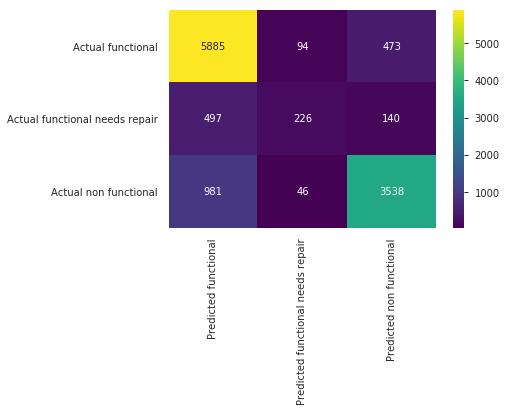

In [133]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}'  for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_val, val_pred);

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
predict_proba(self, X)	Predict class probabilities for X.  

[0.04666667 0.14333333 0.11666667 ... 0.10333333 0.04666667 0.01      ]


False    6032
True     5848
dtype: int64

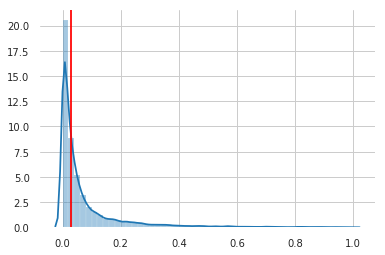

In [134]:
val_pred_proba = clf.predict_proba(X_val)[:,1]
print(val_pred_proba)

threshold = 0.028
ax = sns.distplot(val_pred_proba)
ax.axvline(threshold, color='red')

val_pred = val_pred_proba > threshold
pd.Series(val_pred).value_counts()

In [0]:
def plot_valerr():

  print("Validation score: %.3f" % clf.score(X_val, y_val))
  print("Validation error count:", df_error.shape[0])

  sns.set_style("whitegrid")
  fig, axes = plt.subplots(2, 2, figsize=(16, 14))
  alpha, s = 0.2, 10
  hue="status_group"
  hue_order=['functional', 'non functional', 'functional needs repair']

  sns.scatterplot(x='longitude', y='latitude', 
                  hue=hue,
                  hue_order=hue_order,
#                   data=df_error,
  #                 data=df[df['status_group']=='functional needs repair'], 
  #                 data=df[df['status_group']=='non functional'],
                  data=df[df['status_group']=='functional'],
                  size=np.log(df['population']),
                  alpha=alpha, s=s, ax=axes[0,0])

  sns.scatterplot(x='longitude', y='latitude', 
                  hue=hue, 
                  hue_order=hue_order,
                  data=df_error[df_error['status_group']=='non functional'], 
                  size=np.log(df['population']),
                  alpha=alpha, s=s, ax=axes[0,1])
  axes[0,1].legend(loc='right', bbox_to_anchor=(1.3, 0.5))

  sns.scatterplot(x='longitude', y='latitude', 
                  hue=hue, 
                  hue_order=hue_order,
                  data=df_error[df_error['status_group']=='functional needs repair'], 
                  size=np.log(df['population']),
                  alpha=alpha, s=s, ax=axes[1,0])

  sns.scatterplot(x='longitude', y='latitude',            
                  hue='region_code_str',
                  data=df_error,
                  size=np.log(df['population']),
                  alpha=alpha, s=s, ax=axes[1,1])
  axes[1,1].legend(loc='right', bbox_to_anchor=(1.3, 0.5))

  for ax in chain.from_iterable(zip(*axes)):
    mean = df['longitude'].mean()
    ax.axvline(x=mean, color='black', linewidth=0.5)
    mean = df['latitude'].mean()
    ax.axhline(y=mean, color='black', linewidth=0.5)

  fig.suptitle("Validation Errors", fontsize=30);

Validation score: 0.810
Validation error count: 2254


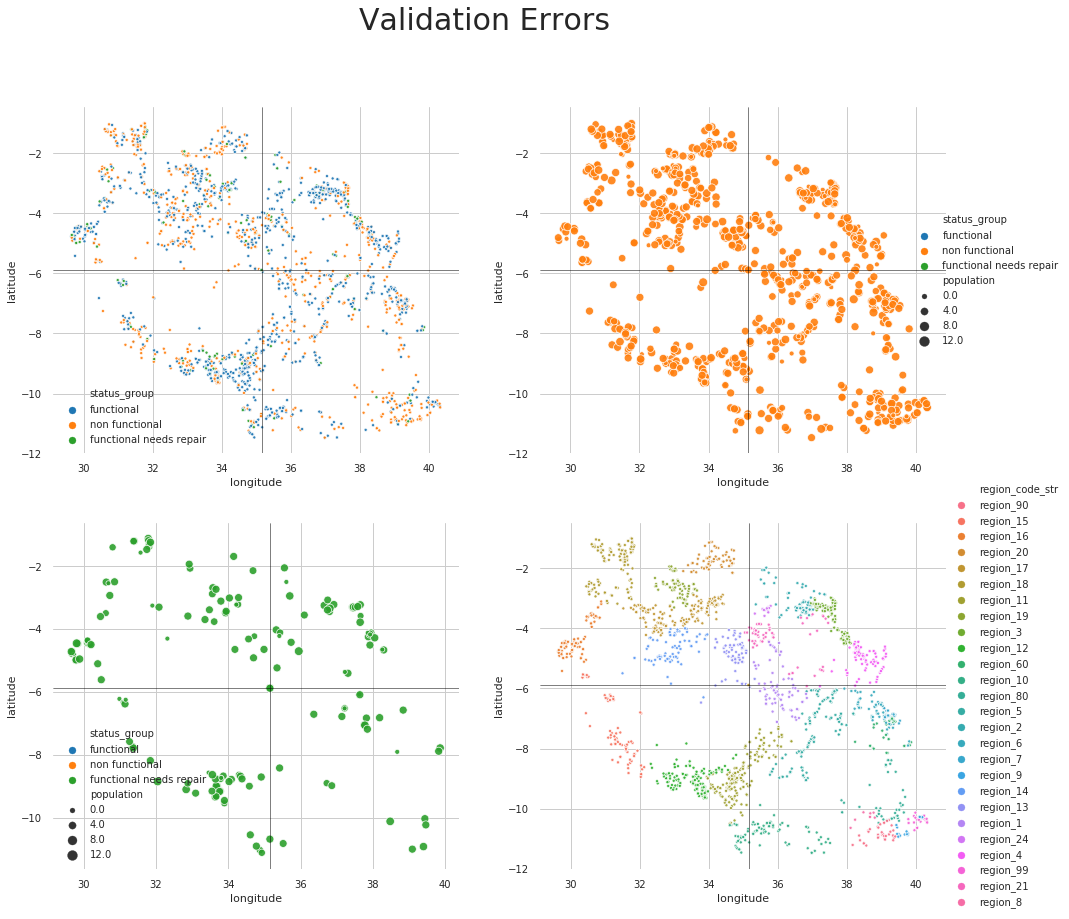

In [0]:
# lg('population') might help...
# Not really

Validation score: 0.812
Validation error count: 2231


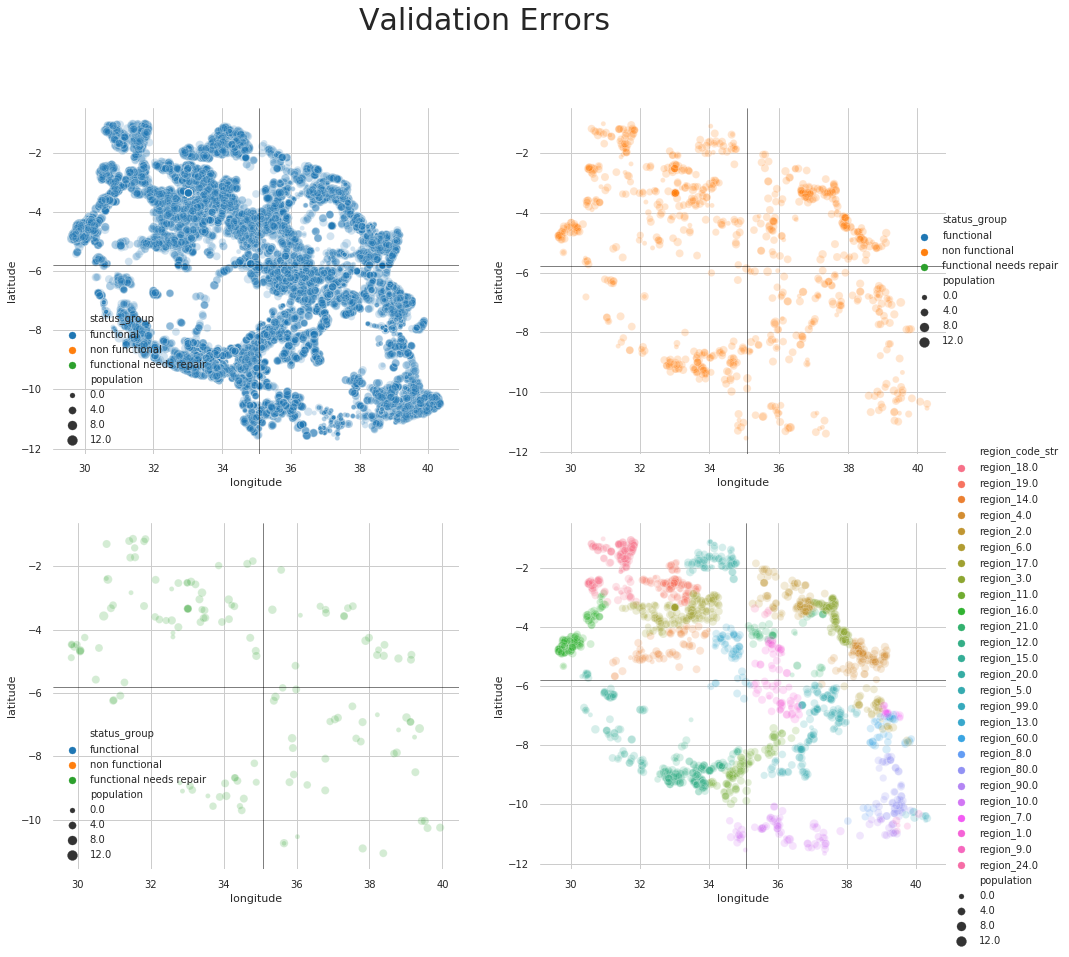

In [135]:
# fixed the data points in the middle, filled with regional medians
plot_valerr()

# Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  

# AdaBoostClassifier

https://programtalk.com/python-examples/sklearn.tree.DecisionTreeRegressor/  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html  
https://www.datacamp.com/community/tutorials/adaboost-classifier-python  

In [0]:
# iris = datasets.load_iris()
# boston = datasets.load_boston()

# def test_gridsearch():
#     # Check that base trees can be grid-searched.
#     # AdaBoost classification
#     boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
#     parameters = {'n_estimators': (1, 2),
#                   'base_estimator__max_depth': (1, 2),
#                   'algorithm': ('SAMME', 'SAMME.R')}
#     clf = GridSearchCV(boost, parameters)
#     clf.fit(iris.data, iris.target)
 
#     # AdaBoost regression
#     boost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
#                               random_state=0)
#     parameters = {'n_estimators': (1, 2),
#                   'base_estimator__max_depth': (1, 2)}
#     clf = GridSearchCV(boost, parameters)
#     clf.fit(boston.data, boston.target)

# test_gridsearch()

# XGBoost

# TPOT

http://epistasislab.github.io/tpot/  